# Dealing with missing data

In [1]:
import pandas as pd
from io import StringIO
csv_data = r'''A,B,C,D
1.0,2.0,3.0,3.0
5.0,6.0,,8.0
0.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,3.0
1,5.0,6.0,NaN,8.0
2,0.0,11.0,12.0,NaN


In [2]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy="mean", axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   3. ],
       [  5. ,   6. ,   7.5,   8. ],
       [  0. ,  11. ,  12. ,   5.5]])

# Handling categorical data

In [3]:
df = pd.DataFrame([
        ['green', 'M', 10.1, 'class1'],
        ['red', 'L', 13.5, 'class2'],
        ['blue', 'XL', 15.3, 'class1']
    ])
df.columns = ['color', 'size', 'price', 'classlabel']

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [5]:
X = df[["color", "size", "price"]].values
lr = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])
X

array([[1, 'M', 10.1],
       [2, 'L', 13.5],
       [0, 'XL', 15.3]], dtype=object)

In [6]:
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [7]:
from sklearn.cross_validation import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

/home/jeovach/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

(10, 13)


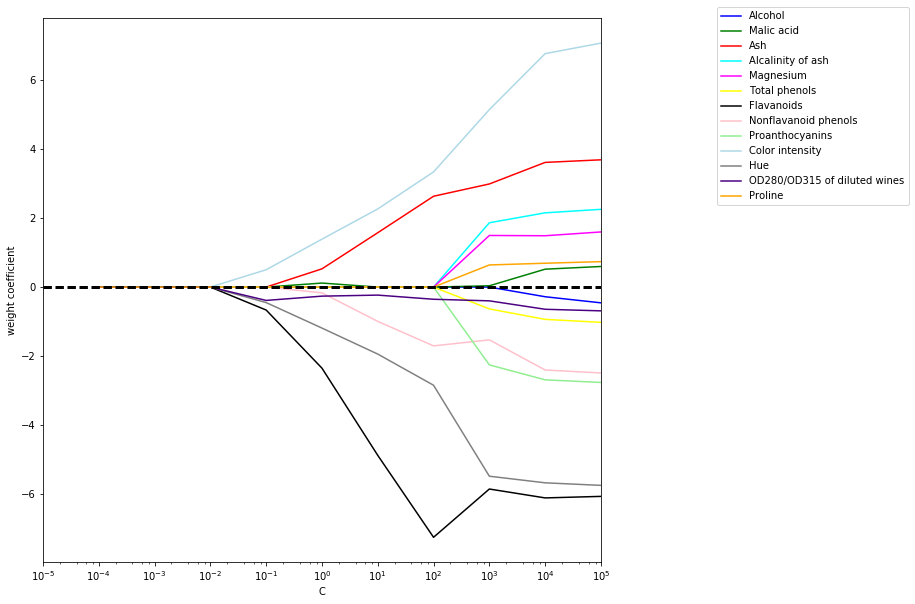

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
colors = ["blue", "green", "red", "cyan",
         "magenta", "yellow", "black",
         "pink", "lightgreen", "lightblue",
         "gray", "indigo", "orange"]
weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty="l1",
                           C=10**c,
                           random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[2])
    params.append(10**c)

weights = np.array(weights)
print(weights.shape)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
    label=df_wine.columns[column+1],
    color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True,
         )
plt.show()

# Sequential feature selection algorithms

In [45]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features,
                scoring = accuracy_score,
                test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                           test_size=self.test_size,
                                                           random_state= self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                X_test, y_test,
                                 self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    
    def trainsform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train,
                           X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

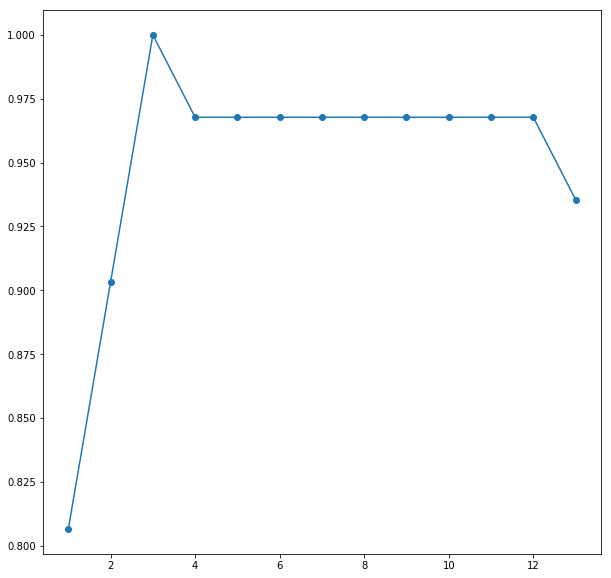

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)
k_feat = [len(k) for k in sbs.subsets_]
plt.figure(figsize=(10,10))
plt.plot(k_feat, sbs.scores_, marker="o")

# Assessing feature importance with random forests

In [51]:
from sklearn.ensemble import RandomForestClassifier
feat_labels  = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=10000,
                               random_state=0,
                               n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2s %0*s %f" %(f + 1, 30,
                          feat_labels[f], importances[f]
                          ))

 1                        Alcohol 0.193591
 2                     Malic acid 0.032208
 3                            Ash 0.013603
 4              Alcalinity of ash 0.036913
 5                      Magnesium 0.033611
 6                  Total phenols 0.050679
 7                     Flavanoids 0.148257
 8           Nonflavanoid phenols 0.012132
 9                Proanthocyanins 0.016570
10                Color intensity 0.123915
11                            Hue 0.073370
12   OD280/OD315 of diluted wines 0.098789
13                        Proline 0.166362
